In [1]:
from transformers import ViTFeatureExtractor, ViTModel
import torch
from datasets import load_dataset
import PIL
from PIL import Image
import nopdb
import numpy as np
import IPython.display as ipd
from timm.data import resolve_data_config, create_transform

In [3]:
model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
#model = torch.load('/common/home/gg676/Downloads/model-best.ckpt')

In [5]:
model

OrderedDict([('text_encoder.word_embedding.weight',
              tensor([[-0.1117, -0.4966,  0.1631,  ...,  0.9230, -0.6661, -0.6180],
                      [ 1.1320,  1.2913, -0.1956,  ..., -1.3459, -0.8913, -0.3044],
                      [ 0.4405,  0.7650, -0.1794,  ..., -0.8837, -0.6481,  1.8302],
                      ...,
                      [ 0.9995, -1.1965,  0.2670,  ..., -0.7126, -0.5795,  0.7460],
                      [ 0.3486, -0.1340,  0.6952,  ...,  0.1052, -1.5558,  0.4057],
                      [ 0.4244,  0.8501,  0.2535,  ..., -0.0158, -1.6062,  1.7005]],
                     device='cuda:0')),
             ('text_encoder.tfs.title.pos_encoder.weight',
              tensor([[-0.1352, -0.2698, -0.0151,  ...,  0.3467,  0.1102,  0.0291],
                      [ 0.0057, -0.0318,  0.0858,  ..., -0.0406, -0.0057, -0.1073],
                      [-0.0401,  0.0784, -0.1733,  ...,  0.1009, -0.0898,  0.0650],
                      ...,
                      [ 0.0192, -0.019

In [6]:
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

In [7]:
config = resolve_data_config({}, model=model)
transform = create_transform(**config)

In [8]:
image = Image.open('/common/users/gg676/test_flattened/ff611e83ca.jpg').convert('RGB')

In [9]:
inputs = feature_extractor(image, return_tensors="pt")

In [10]:
with nopdb.capture_call(model._modules['encoder'].layer[4].attention.attention.forward) as attn_call:
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True, output_hidden_states=True)

In [11]:
attn_call.args.keys()

odict_keys(['self', 'hidden_states', 'head_mask', 'output_attentions'])

In [12]:
attn_call.return_value[1][0].shape

torch.Size([12, 197, 197])

In [57]:
attn_call#.args['hidden_states'].shape

CallCapture(name='forward', args=OrderedDict(self=ViTSelfAttention(
  (query): Linear(in_features=768, out_features=768, bias=True)
  (key): Linear(in_features=768, out_features=768, bias=True)
  (value): Linear(in_features=768, out_features=768, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
), hidden_states=tensor([[[ 6.2558e-02,  3.5096e-06, -6.7177e-02,  ..., -2.8272e-01,
           3.2829e-02, -1.0136e-01],
         [ 1.2319e-01,  2.1958e-01,  2.4245e-01,  ..., -2.5595e-03,
           1.9562e-01, -7.3481e-02],
         [ 5.6593e-02,  1.8626e-01, -1.0463e-01,  ...,  3.7895e-02,
           2.0030e-01, -1.4483e-02],
         ...,
         [-5.7039e-02,  2.6715e-01, -2.5452e-01,  ..., -1.2282e-01,
          -1.7359e-01,  2.4302e-01],
         [-9.3926e-02,  3.2373e-01,  7.1991e-02,  ..., -1.0675e-01,
          -2.9791e-01,  2.4137e-01],
         [-1.1781e-01,  2.1085e-01, -7.4308e-02,  ...,  3.6181e-02,
          -2.3862e-01,  1.4053e-01]]]), head_mask=None, output_attentions=T

In [13]:
model._modules['encoder'].layer[0].attention

ViTAttention(
  (attention): ViTSelfAttention(
    (query): Linear(in_features=768, out_features=768, bias=True)
    (key): Linear(in_features=768, out_features=768, bias=True)
    (value): Linear(in_features=768, out_features=768, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (output): ViTSelfOutput(
    (dense): Linear(in_features=768, out_features=768, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
)

In [14]:
model.__dict__

{'training': False,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_modules': OrderedDict([('embeddings',
               ViTEmbeddings(
                 (patch_embeddings): PatchEmbeddings(
                   (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
                 )
                 (dropout): Dropout(p=0.0, inplace=False)
               )),
              ('encoder',
               ViTEncoder(
                 (layer): ModuleList(
                   (0): ViTLayer(
                     (attention): ViTAttention(
                       (attention): ViTSelfAttention(
                         (query): Linear(in_features=768, out_features=768, bias=True)
                         (key): Linea

In [15]:

def inv_normalize(tensor):
    #print("tensor", type(tensor))
    tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min()) * (256 - 1e-5)
    #print("after tensor: ", tensor)
    return tensor

def inv_transform(tensor, normalize=True):
    #print("transform: ", tensor)
    tensor = inv_normalize(tensor)
    array = tensor.detach().cpu().numpy()[0]
    #print(array.shape)
    array = array.transpose(1, 2, 0).astype(np.uint8)
    return PIL.Image.fromarray(array)

In [16]:
def plot_weights(inputs, patch_weights):
    plot = inv_normalize(inputs.copy()['pixel_values'])
    for i in range(patch_weights.shape[0]):
        x = i * 16 % 224
        y = i // (224 // 16) * 16
        plot[:, y:y + 16, x:x + 16] *= patch_weights[i]
    ipd.display(inv_transform(plot, normalize=False))

In [17]:
def plot_attention(inputs, attn):
    with torch.no_grad():
        # Loop over attention heads
        for h_weights in attn:
            h_weights = h_weights.mean(axis=-2)  # Average over all attention keys
            h_weights = h_weights[1:]  # Skip the [class] token
            plot_weights(inputs, h_weights)
            


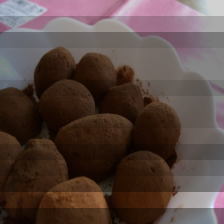

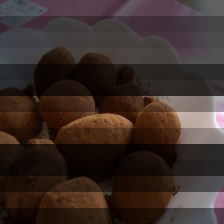

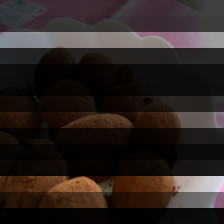

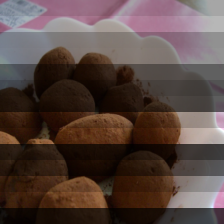

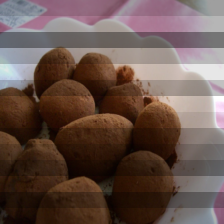

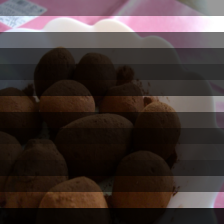

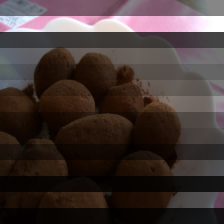

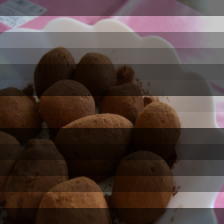

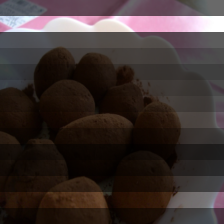

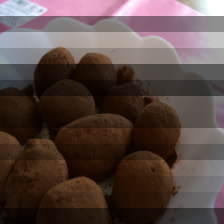

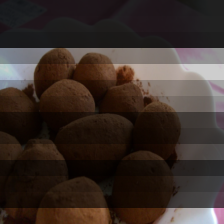

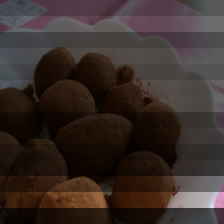

In [18]:
plot_attention(inputs, attn_call.return_value[1][0])

In [47]:
attn_call.return_value[1][0].shape

torch.Size([12, 197, 197])